Make sure you extracted following files into the same directory as this notebook:
- training_50_dih.joblib
- validation_dih.joblib
- le.joblib
- ohe.joblib

And run 'pip install joblib'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time

import data_loader as dl
import data_transformer as dt

Modify the path below

In [2]:
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

The data_lim is important because so far the full 13000 proteins crashes my system with 16Gb of ram

Load training data

In [3]:
file_name = 'training_50'
data_lim = 5000
prim_train, evo_train, dih_train, mask_train = (dl.parse_primary_from_file(txt_data_path + file_name, data_lim), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name, data_lim),
                                                dl.load_file('./'+file_name+'_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name, data_lim))
dih_train = dih_train[:data_lim]
len(prim_train), prim_train[0].shape, len(evo_train), evo_train[0].shape, len(dih_train), dih_train[0].shape, len(mask_train), mask_train[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 5000/5000 [00:00<00:00, 68457.87it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(5000, (70, 20), 5000, (70, 21), 5000, (70, 3), 5000, (70,))

Load validation data

In [4]:
file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))
len(prim_valid), prim_valid[0].shape, len(evo_valid), evo_valid[0].shape, len(dih_valid), dih_valid[0].shape, len(mask_valid), mask_valid[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 59373.36it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(224, (269, 20), 224, (269, 21), 224, (269, 3), 224, (269,))

Pad the data and limit protein length. Prepare the data for training

In [5]:
max_len = 500
prim_, evo_, dih_, mask_ = dt.limit_length_and_pad(prim_train, evo_train, dih_train, mask_train, max_len)
x_train, y_train = np.concatenate([prim_, evo_], axis=2), dih_
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v

padded
(4764,) (70, 20)
padded
(4764,) (70, 21)
padded
(4764,) (70, 3)
padded
(4764,) (70, 1)
padded
(213,) (269, 20)
padded
(213,) (269, 21)
padded
(213,) (269, 3)
padded
(213,) (269, 1)


In [6]:
x_train.shape

(4764, 500, 41)

In [7]:
x_train[np.logical_not(mask_)] = -99.
x_valid[np.logical_not(mask_v)] = -99.

In [8]:
histories = []

In [21]:
def loss360(y_true, y_pred):
    return tf.reduce_mean(tf.abs(tf.atan2(tf.sin(y_true - y_pred), tf.cos(y_true - y_pred))))

def pcc(y_true, y_pred):
    return tf.reduce_mean(tf.contrib.metrics.streaming_pearson_correlation(tf.cos(y_true), tf.cos(y_pred)))

Run a simple regression task to check if it trains on the data

In [53]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Lambda, Masking, concatenate, Subtract
from keras.layers import LSTM, Conv1D, Input

n_angles = 2
inputs = Input(shape=(max_len,41))
x1 = Masking(mask_value=-99.)(inputs)
x2 = LSTM(10, return_sequences=True)(x1)
x12 = concatenate([x1,x2])
x3 = LSTM(10, return_sequences=True)(x12)
x4 = Dense(n_angles, activation='sigmoid')(x3)
y = Lambda(lambda x: (x-0.5)*2*np.pi)(x4)
model = Model(inputs=inputs, outputs=y)

# model = Sequential()
# model.add(Masking(mask_value=-1.))
# model.add(LSTM(128, return_sequences=True))
# # model.add(LSTM(128, return_sequences=True))
# # model.add(Conv1D(32, 15, padding='same'))
# # model.add(Conv1D(64, 15, padding='same'))
# # model.add(Conv1D(128, 15, padding='same'))
# # model.add(Dropout(0.5))
# model.add(Dense(3, activation='tanh'))
# model.add(Lambda(lambda x: x*np.pi))

model.compile(loss=loss360,
              optimizer='adam',
              metrics=[loss360, pcc, 'mean_absolute_error'])

with tf.Session() as sess:
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    history = model.fit(x_train, y_train[:,:,:n_angles], validation_data=(x_valid, y_valid[:,:,:n_angles]), batch_size=100, epochs=5)
    histories.append(history)

Train on 4764 samples, validate on 213 samples
Epoch 1/5
4764/4764 [==============================] - 50s 11ms/step - loss: 0.3710 - loss360: 0.3710 - pcc: nan - mean_absolute_error: 0.3744 - val_loss: 0.3571 - val_loss360: 0.3571 - val_pcc: 0.4326 - val_mean_absolute_error: 0.3608
Epoch 2/5
4764/4764 [==============================] - 47s 10ms/step - loss: 0.3453 - loss360: 0.3453 - pcc: 0.4488 - mean_absolute_error: 0.3490 - val_loss: 0.3466 - val_loss360: 0.3466 - val_pcc: 0.4618 - val_mean_absolute_error: 0.3509
Epoch 3/5
4764/4764 [==============================] - 47s 10ms/step - loss: 0.3360 - loss360: 0.3360 - pcc: 0.4721 - mean_absolute_error: 0.3411 - val_loss: 0.3377 - val_loss360: 0.3377 - val_pcc: 0.4857 - val_mean_absolute_error: 0.3442
Epoch 4/5
4764/4764 [==============================] - 47s 10ms/step - loss: 0.3286 - loss360: 0.3286 - pcc: 0.4991 - mean_absolute_error: 0.3355 - val_loss: 0.3311 - val_loss360: 0.3311 - val_pcc: 0.5129 - val_mean_absolute_error: 0.3389


In [54]:
with tf.Session() as sess:
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    pred = model.predict(x_valid)

0.501561

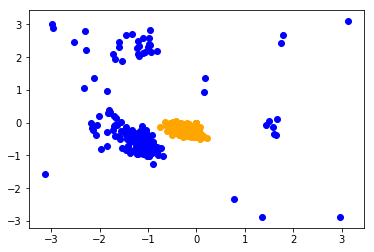

In [64]:
n = 150
plt.scatter(y_valid[n,:,0], y_valid[n,:,1], c='blue')
plt.scatter(pred[n,:,0], pred[n,:,1], c='orange')

np.mean(np.abs(y_valid[n,:,:2] - pred[n]))

In [37]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=100, epochs=10)

Train on 1892 samples, validate on 213 samples
Epoch 1/10
1892/1892 [==============================] - 21s 11ms/step - loss: 0.5397 - mean_absolute_error: 0.5397 - val_loss: 0.5528 - val_mean_absolute_error: 0.5528
Epoch 2/10
1892/1892 [==============================] - 21s 11ms/step - loss: 0.5390 - mean_absolute_error: 0.5390 - val_loss: 0.5522 - val_mean_absolute_error: 0.5522
Epoch 3/10
1892/1892 [==============================] - 21s 11ms/step - loss: 0.5384 - mean_absolute_error: 0.5384 - val_loss: 0.5513 - val_mean_absolute_error: 0.5513
Epoch 4/10
1892/1892 [==============================] - 21s 11ms/step - loss: 0.5376 - mean_absolute_error: 0.5376 - val_loss: 0.5506 - val_mean_absolute_error: 0.5506
Epoch 5/10
1892/1892 [==============================] - 21s 11ms/step - loss: 0.5378 - mean_absolute_error: 0.5378 - val_loss: 0.5503 - val_mean_absolute_error: 0.5503
Epoch 6/10
1892/1892 [==============================] - 21s 11ms/step - loss: 0.5367 - mean_absolute_error: 0.536

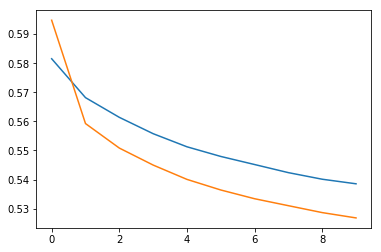

In [27]:
plt.plot(histories[0].history['val_mean_absolute_error'])
plt.plot(histories[0].history['mean_absolute_error'])